In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Reshape, LSTM, add, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_uniform, he_uniform
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from utils import *


Device mapping: no known devices.


## Data Loading

(2115, 22, 1000)


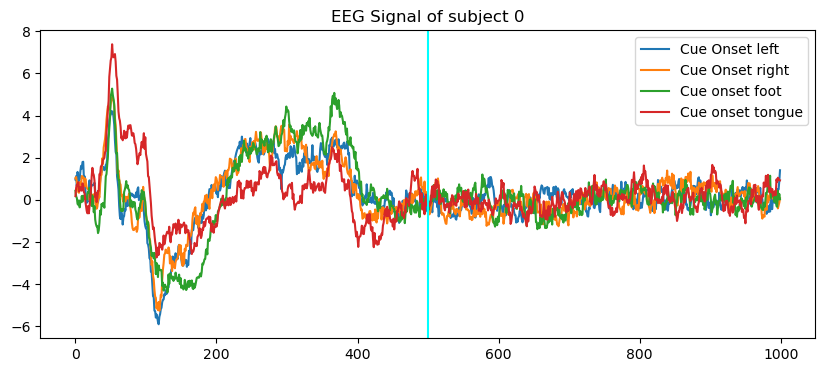

In [2]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

y_train_valid -= 769
y_test -= 769

ch_data = X_train_valid[:,0,:]

class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)

class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)

plt.figure(figsize=(10, 4))
plt.title('EEG Signal of subject 0')
plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

### Raw Data

In [3]:
X_train, y_train, X_test, y_test = init_data(subject=None, verbose=True)
ind_valid = np.random.choice(X_train.shape[0], int(0.1 * X_train.shape[0]), replace=False)
ind_train = np.array(list(set(range(X_train.shape[0])).difference(set(ind_valid))))
(x_train_raw, x_valid_raw) = X_train[ind_train], X_train[ind_valid]
(y_train_raw, y_valid_raw) = y_train[ind_train], y_train[ind_valid]
x_train_raw, y_train_raw, x_valid_raw, y_valid_raw, x_test_raw, y_test_raw = load_data(x_train_raw, y_train_raw, x_valid_raw, y_valid_raw, X_test, y_test, verbose=True)

Training data shape: (1904, 1000, 1, 22) Training target shape: (1904, 4)
Validation data shape: (211, 1000, 1, 22) Validation target shape: (211, 4)
Testing data shape: (443, 1000, 1, 22) Testing target shape: (443, 4)


### Feature Scaling

In [4]:
x_mean = np.mean(X_train, axis=0)
x_std = np.std(X_train, axis=0)
X_train_fc = X_train - x_mean
X_train_fc /= x_std
X_test_fc = X_test - x_mean
X_test_fc /= x_std
ind_valid = np.random.choice(X_train_fc.shape[0], int(0.1 * X_train.shape[0]), replace=False)
ind_train = np.array(list(set(range(X_train_fc.shape[0])).difference(set(ind_valid))))
(x_train_fc, x_valid_fc) = X_train[ind_train], X_train[ind_valid]
(y_train_fc, y_valid_fc) = y_train[ind_train], y_train[ind_valid]
x_train_fc, y_train_fc, x_valid_fc, y_valid_fc, x_test_fc, y_test_fc = load_data(x_train_fc, y_train_fc, x_valid_fc, y_valid_fc, X_test_fc, y_test, verbose=True)

Training data shape: (1904, 1000, 1, 22) Training target shape: (1904, 4)
Validation data shape: (211, 1000, 1, 22) Validation target shape: (211, 4)
Testing data shape: (443, 1000, 1, 22) Testing target shape: (443, 4)


### Data Augmentation

In [5]:
X_train_aug, y_train_aug, X_test_aug, y_test_aug, X_valid_aug, y_valid_aug= preprocess_data(X_train, y_train, X_test, y_test, verbose=True)
x_train_aug, y_train_aug, x_valid_aug, y_valid_aug, x_test_aug, y_test_aug = load_data(X_train_aug, y_train_aug, X_valid_aug, y_valid_aug, X_test_aug, y_test_aug, verbose=True)

Training data shape: (7616, 22, 250) Training target shape: (7616,)
Testing data shape: (443, 22, 250) Testing target shape: (443,)
Training data shape: (7616, 250, 1, 22) Training target shape: (7616, 4)
Validation data shape: (844, 250, 1, 22) Validation target shape: (844, 4)
Testing data shape: (443, 250, 1, 22) Testing target shape: (443, 4)


### Data Windowing

In [6]:
X_train_window, y_train_window = window_data(X_train, y_train, window_size=800,stride=100, verbose=True)
X_test_window, y_test_window = window_data(X_test, y_test, window_size=800,stride=100, verbose=True)
X_train_window, y_train_window, X_test_window, y_test_window, X_valid_window, y_valid_window= preprocess_data(X_train_window, y_train_window, X_test_window, y_test_window, verbose=True)
x_train_window, y_train_window, x_valid_window, y_valid_window, x_test_window, y_test_window = load_data(X_train_window, y_train_window, X_valid_window, y_valid_window, X_test_window, y_test_window, verbose=True)

Windowed Training data shape: (4230, 22, 800) Windowed Training target shape: (4230,)
Windowed Training data shape: (886, 22, 800) Windowed Training target shape: (886,)
Training data shape: (15228, 22, 250) Training target shape: (15228,)
Testing data shape: (886, 22, 250) Testing target shape: (886,)
Training data shape: (15228, 250, 1, 22) Training target shape: (15228, 4)
Validation data shape: (1692, 250, 1, 22) Validation target shape: (1692, 4)
Testing data shape: (886, 250, 1, 22) Testing target shape: (886, 4)


### Data CWT

In [7]:
X_train, y_train, X_test, y_test = init_data(subject=None)
X_train, y_train, X_test, y_test, X_valid, y_valid = preprocess_data(X_train, y_train, X_test, y_test, verbose=True)

scales = np.arange(1, 7)

X_train_cwt = cwt_transform(X_train, scales, ricker, verbose=True)
X_valid_cwt = cwt_transform(X_valid, scales, ricker, verbose=True)
X_test_cwt = cwt_transform(X_test, scales, ricker, verbose=True)

y_train_cwt = to_categorical(y_train, 4)
y_valid_cwt = to_categorical(y_valid, 4)
y_test_cwt = to_categorical(y_test, 4)

x_train_cwt = np.swapaxes(X_train_cwt, 1, 3)
x_valid_cwt = np.swapaxes(X_valid_cwt, 1, 3)
x_test_cwt = np.swapaxes(X_test_cwt, 1, 3)


Training data shape: (7616, 22, 250) Training target shape: (7616,)
Testing data shape: (443, 22, 250) Testing target shape: (443,)
CWT Transformed data shape: (7616, 22, 6, 250)
CWT Transformed data shape: (844, 22, 6, 250)
CWT Transformed data shape: (443, 22, 6, 250)


## MaxPool_CNN

### Sample Architecture (Slight change based on different datasets)

In [8]:
dropout = 0.55
learning_rate = 0.001
epochs = 50
weight_decay = 0.05

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(12,1), padding='same', activation='elu', input_shape=(250,1,22), kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=64, kernel_size=(12,1), padding='same', activation='elu', kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=128, kernel_size=(10,1), padding='same', activation='elu', kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=256, kernel_size=(10,1), padding='same', activation='elu', kernel_initializer='glorot_uniform'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Flatten())
model.add(Dense(50, activation='elu', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay), kernel_initializer='glorot_uniform'))
model.add(Dense(4, activation='softmax', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay), kernel_initializer='glorot_uniform'))
            

optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 250, 1, 32)        8480      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 84, 1, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 84, 1, 32)         128       
_________________________________________________________________
dropout (Dropout)            (None, 84, 1, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 84, 1, 64)         24640     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 1, 64)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 1, 64)         2

## Train/Test

### On Raw Data

Epoch 1/50
30/30 [==============================] - 3s 89ms/step - loss: 7.1592 - accuracy: 0.2710 - val_loss: 10.4328 - val_accuracy: 0.2844
Epoch 2/50
30/30 [==============================] - 3s 84ms/step - loss: 5.6506 - accuracy: 0.3172 - val_loss: 4.8352 - val_accuracy: 0.3270
Epoch 3/50
30/30 [==============================] - 2s 83ms/step - loss: 4.5265 - accuracy: 0.3477 - val_loss: 3.9601 - val_accuracy: 0.3886
Epoch 4/50
30/30 [==============================] - 3s 84ms/step - loss: 3.7031 - accuracy: 0.3461 - val_loss: 3.2958 - val_accuracy: 0.3839
Epoch 5/50
30/30 [==============================] - 3s 83ms/step - loss: 3.0622 - accuracy: 0.3824 - val_loss: 2.8111 - val_accuracy: 0.3791
Epoch 6/50
30/30 [==============================] - 3s 85ms/step - loss: 2.6152 - accuracy: 0.3776 - val_loss: 2.4067 - val_accuracy: 0.4028
Epoch 7/50
30/30 [==============================] - 3s 86ms/step - loss: 2.2642 - accuracy: 0.4034 - val_loss: 2.1624 - val_accuracy: 0.3744
Epoch 8/50
3

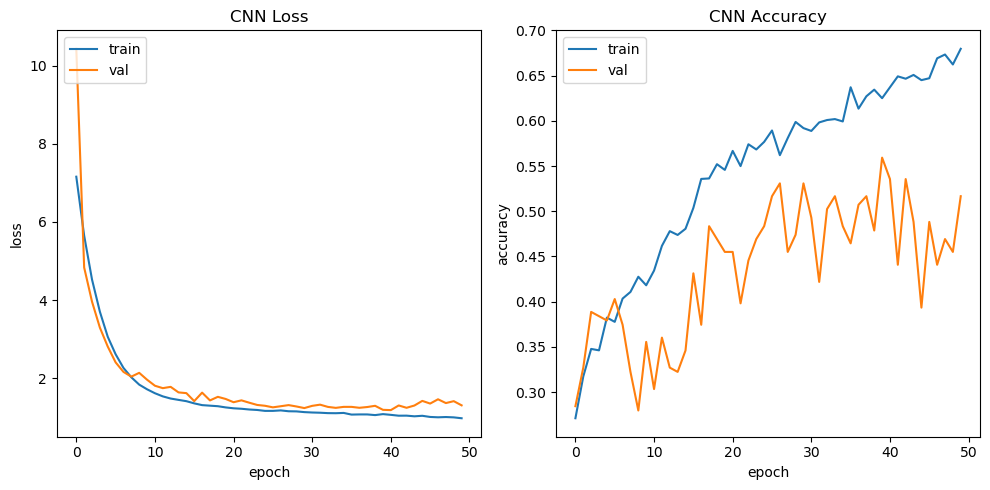

Test accuracy:0.5936794877052307


In [9]:
dropout = 0.55
learning_rate = 0.001
epochs = 50
weight_decay = 0.05

model = Sequential()

model.add(Conv2D(filters=25, kernel_size=(12,1), padding='same', activation='elu', input_shape=(1000,1,22), kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=50, kernel_size=(12,1), padding='same', activation='elu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Flatten())
model.add(Dense(50, activation='elu', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay), kernel_initializer='he_uniform'))
model.add(Dense(4, activation='softmax', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay), kernel_initializer='he_uniform'))
            
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.1)
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

results = model.fit(x_train_raw,
            y_train_raw,
            batch_size=64,
            epochs=epochs,
            validation_data=(x_valid_raw, y_valid_raw), callbacks=[lr_callback], verbose=1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('CNN Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('CNN Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.tight_layout()
plt.show()

score = model.evaluate(x_test_raw, y_test_raw, verbose=0)
print(f'Test accuracy:{score[1]}')


### On Scaled Data

Epoch 1/50
30/30 [==============================] - 3s 95ms/step - loss: 7.1206 - accuracy: 0.2789 - val_loss: 8.2666 - val_accuracy: 0.3081
Epoch 2/50
30/30 [==============================] - 2s 83ms/step - loss: 5.5063 - accuracy: 0.3272 - val_loss: 5.0330 - val_accuracy: 0.3223
Epoch 3/50
30/30 [==============================] - 2s 75ms/step - loss: 4.4278 - accuracy: 0.3346 - val_loss: 3.9205 - val_accuracy: 0.2891
Epoch 4/50
30/30 [==============================] - 2s 77ms/step - loss: 3.5852 - accuracy: 0.3708 - val_loss: 3.2858 - val_accuracy: 0.2891
Epoch 5/50
30/30 [==============================] - 2s 77ms/step - loss: 2.9803 - accuracy: 0.3661 - val_loss: 2.8029 - val_accuracy: 0.3555
Epoch 6/50
30/30 [==============================] - 2s 78ms/step - loss: 2.5140 - accuracy: 0.4007 - val_loss: 2.4087 - val_accuracy: 0.3602
Epoch 7/50
30/30 [==============================] - 2s 79ms/step - loss: 2.2039 - accuracy: 0.4023 - val_loss: 2.1296 - val_accuracy: 0.4028
Epoch 8/50
30

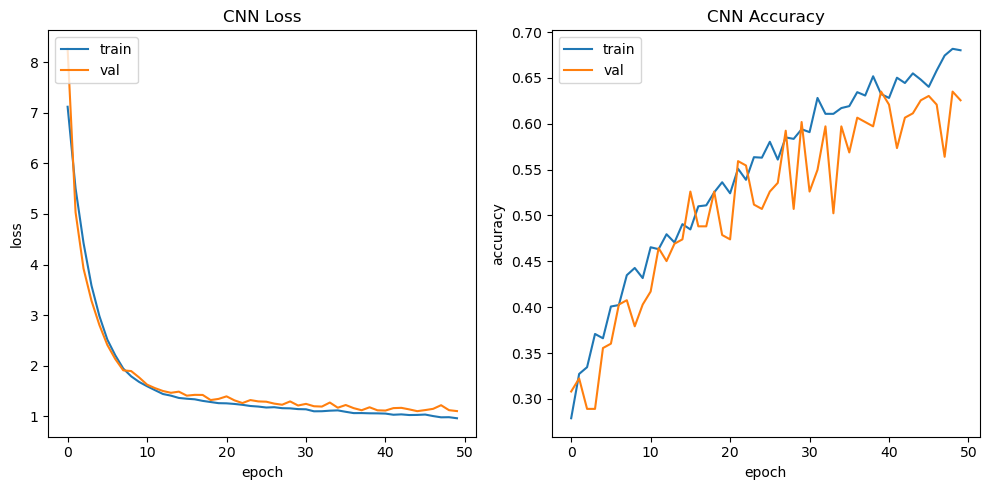

Test accuracy:0.2460496574640274


In [10]:
dropout = 0.55
learning_rate = 0.001
epochs = 50
weight_decay = 0.05

model = Sequential()

model.add(Conv2D(filters=25, kernel_size=(12,1), padding='same', activation='elu', input_shape=(1000,1,22), kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=50, kernel_size=(12,1), padding='same', activation='elu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Flatten())
model.add(Dense(50, activation='elu', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay), kernel_initializer='he_uniform'))
model.add(Dense(4, activation='softmax', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay), kernel_initializer='he_uniform'))
            
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.1)
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

results = model.fit(x_train_fc,
            y_train_fc,
            batch_size=64,
            epochs=epochs,
            validation_data=(x_valid_fc, y_valid_fc), callbacks=[lr_callback], verbose=1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('CNN Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('CNN Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.tight_layout()
plt.show()

score = model.evaluate(x_test_fc, y_test_fc, verbose=0)
print(f'Test accuracy:{score[1]}')


### On Aug Data

Epoch 1/100
119/119 [==============================] - 3s 25ms/step - loss: 5.5083 - accuracy: 0.2907 - val_loss: 3.7303 - val_accuracy: 0.3981
Epoch 2/100
119/119 [==============================] - 3s 23ms/step - loss: 3.0462 - accuracy: 0.3440 - val_loss: 2.3957 - val_accuracy: 0.3910
Epoch 3/100
119/119 [==============================] - 3s 23ms/step - loss: 2.0593 - accuracy: 0.3776 - val_loss: 1.7929 - val_accuracy: 0.4479
Epoch 4/100
119/119 [==============================] - 3s 24ms/step - loss: 1.6138 - accuracy: 0.4315 - val_loss: 1.6162 - val_accuracy: 0.3780
Epoch 5/100
119/119 [==============================] - 3s 23ms/step - loss: 1.4013 - accuracy: 0.4594 - val_loss: 1.4287 - val_accuracy: 0.4265
Epoch 6/100
119/119 [==============================] - 3s 23ms/step - loss: 1.3056 - accuracy: 0.4782 - val_loss: 1.2839 - val_accuracy: 0.4348
Epoch 7/100
119/119 [==============================] - 3s 23ms/step - loss: 1.2518 - accuracy: 0.4852 - val_loss: 1.2396 - val_accuracy:

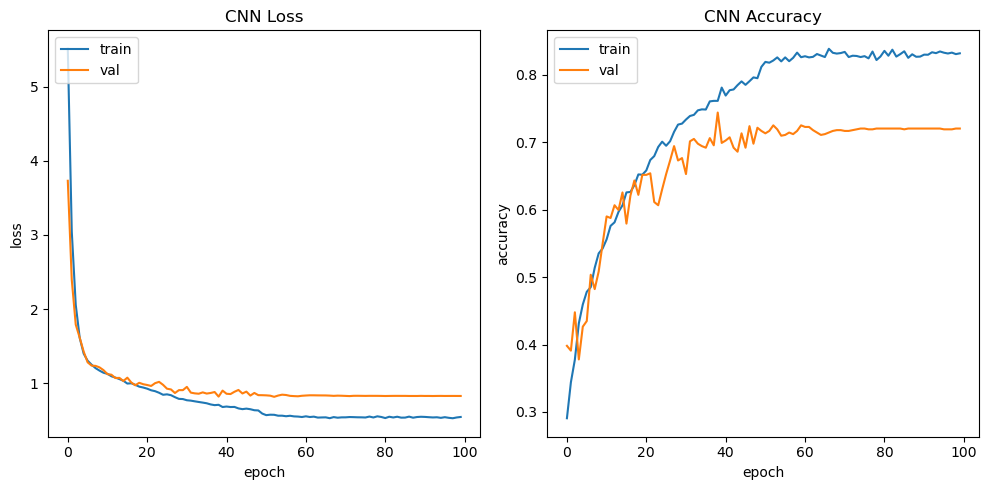

Test accuracy:0.7200902700424194


In [11]:
dropout = 0.55
learning_rate = 0.0007
epochs = 100
weight_decay = 0.05

model = Sequential()

model.add(Conv2D(filters=25, kernel_size=(12,1), padding='same', activation='elu', input_shape=(250,1,22), kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=50, kernel_size=(12,1), padding='same', activation='elu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Flatten())
model.add(Dense(50, activation='elu', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay), kernel_initializer='he_uniform'))
model.add(Dense(4, activation='softmax', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay), kernel_initializer='he_uniform'))
            
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.1)
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

results = model.fit(x_train_aug,
            y_train_aug,
            batch_size=64,
            epochs=epochs,
            validation_data=(x_valid_aug, y_valid_aug), callbacks=[lr_callback], verbose=1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('CNN Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('CNN Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.tight_layout()
plt.show()

score = model.evaluate(x_test_aug, y_test_aug, verbose=0)
print(f'Test accuracy:{score[1]}')

#### Test on subject1

In [13]:
X_train_s1, y_train_s1, X_test_s1, y_test_s1 = init_data(subject=0, verbose=False)
X_train_aug_s1, y_train_aug_s1, X_test_aug_s1, y_test_aug_s1, X_valid_aug_s1, y_valid_aug_s1= preprocess_data(X_train_s1, y_train_s1, X_test_s1, y_test_s1, verbose=False)
_, _, _, _, x_test_aug_s1, y_test_aug_s1 = load_data(X_train_aug_s1, y_train_aug_s1, X_valid_aug_s1, y_valid_aug_s1, X_test_aug_s1, y_test_aug_s1, verbose=False)
score = model.evaluate(x_test_aug_s1, y_test_aug_s1, verbose=0)
print(f'Test accuracy on subject 1:{score[1]}')

Test accuracy on subject 1:0.6600000262260437


### On Windowed Data

Epoch 1/100
238/238 [==============================] - 6s 27ms/step - loss: 2.0335 - accuracy: 0.3158 - val_loss: 1.5312 - val_accuracy: 0.3233
Epoch 2/100
238/238 [==============================] - 6s 25ms/step - loss: 1.3561 - accuracy: 0.4188 - val_loss: 1.2965 - val_accuracy: 0.4119
Epoch 3/100
238/238 [==============================] - 6s 27ms/step - loss: 1.2241 - accuracy: 0.4869 - val_loss: 1.2067 - val_accuracy: 0.4929
Epoch 4/100
238/238 [==============================] - 6s 25ms/step - loss: 1.1243 - accuracy: 0.5428 - val_loss: 1.1163 - val_accuracy: 0.5278
Epoch 5/100
238/238 [==============================] - 6s 24ms/step - loss: 1.0508 - accuracy: 0.5856 - val_loss: 1.0333 - val_accuracy: 0.5887
Epoch 6/100
238/238 [==============================] - 6s 25ms/step - loss: 0.9967 - accuracy: 0.6170 - val_loss: 0.9718 - val_accuracy: 0.6212
Epoch 7/100
238/238 [==============================] - 6s 25ms/step - loss: 0.9496 - accuracy: 0.6407 - val_loss: 0.9011 - val_accuracy:

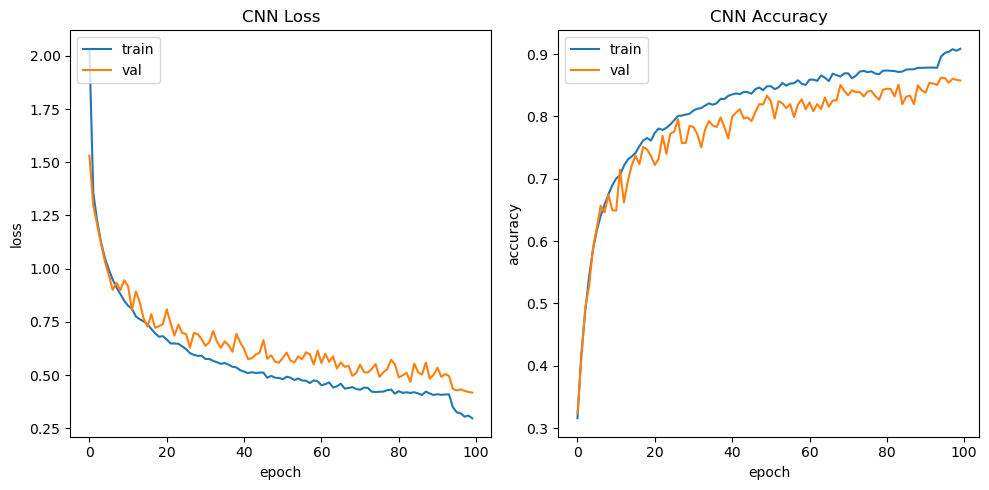

Test accuracy:0.709932267665863


In [17]:
dropout = 0.5
learning_rate = 0.003
epochs = 100
weight_decay = 0.01

model = Sequential()

model.add(Conv2D(filters=25, kernel_size=(12,1), padding='same', activation='elu', input_shape=(250,1,22), kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=50, kernel_size=(12,1), padding='same', activation='elu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Conv2D(filters=150, kernel_size=(10,1), padding='same', activation='elu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
model.add(BatchNormalization())
model.add(Dropout(dropout))



model.add(Flatten())
model.add(Dense(50, activation='elu', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay), kernel_initializer='he_uniform'))
model.add(Dense(4, activation='softmax', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay), kernel_initializer='he_uniform'))
            
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.1)
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)

model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])

results = model.fit(x_train_window,
            y_train_window,
            batch_size=64,
            epochs=epochs,
            validation_data=(x_valid_window, y_valid_window), callbacks=[lr_callback], verbose=1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('CNN Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('CNN Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.tight_layout()
plt.show()

score = model.evaluate(x_test_window, y_test_window, verbose=0)
print(f'Test accuracy:{score[1]}')


## Train based on subjects (Use Aug data since better generalization)

In [24]:
acc_subjects = []
acc_subject_v_all = []
X_train, y_train, X_test, y_test = init_data(subject=None, verbose=False)
X_train_aug, y_train_aug, X_test_aug, y_test_aug, X_valid_aug, y_valid_aug= preprocess_data(X_train, y_train, X_test, y_test, verbose=False)
_, _, _, _, x_test_aug_all, y_test_aug_all = load_data(X_train_aug, y_train_aug, X_valid_aug, y_valid_aug, X_test_aug, y_test_aug, verbose=False)

for i in range(9):
    X_train, y_train, X_test, y_test = init_data(subject=i, verbose=False)
    X_train_aug, y_train_aug, X_test_aug, y_test_aug, X_valid_aug, y_valid_aug= preprocess_data(X_train, y_train, X_test, y_test, verbose=False)
    x_train_aug, y_train_aug, x_valid_aug, y_valid_aug, x_test_aug, y_test_aug = load_data(X_train_aug, y_train_aug, X_valid_aug, y_valid_aug, X_test_aug, y_test_aug, verbose=False)

    dropout = 0.55
    learning_rate = 0.0007
    epochs = 100
    weight_decay = 0.05
    
    model = Sequential()
    
    model.add(Conv2D(filters=25, kernel_size=(12,1), padding='same', activation='elu', input_shape=(250,1,22), kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=50, kernel_size=(12,1), padding='same', activation='elu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Flatten())
    model.add(Dense(50, activation='elu', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay), kernel_initializer='he_uniform'))
    model.add(Dense(4, activation='softmax', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay), kernel_initializer='he_uniform'))

    early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,        
                           verbose=1,         
                           mode='min',         
                           restore_best_weights=True)
    lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.1)
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    
    model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])
    
    results = model.fit(x_train_aug,
                y_train_aug,
                batch_size=64,
                epochs=epochs,
                validation_data=(x_valid_aug, y_valid_aug), callbacks=[lr_callback], verbose=0)

    score = model.evaluate(x_test_aug, y_test_aug, verbose=0)
    print(f'Test accuracy for subject {i}: {score[1]}')
    acc_subjects.append(score[1])

    score = model.evaluate(x_test_aug_all, y_test_aug_all, verbose=0)
    print(f'Test accuracy for subject {i} to all data: {score[1]}')
    acc_subject_v_all.append(score[1])

print(acc_subjects)
print(acc_subject_v_all)
        

Test accuracy for subject 0: 0.5199999809265137
Test accuracy for subject 0 to all data: 0.4040631949901581
Test accuracy for subject 1: 0.5400000214576721
Test accuracy for subject 1 to all data: 0.3611738085746765
Test accuracy for subject 2: 0.6200000047683716
Test accuracy for subject 2 to all data: 0.3927765190601349
Test accuracy for subject 3: 0.6399999856948853
Test accuracy for subject 3 to all data: 0.42663657665252686
Test accuracy for subject 4: 0.8085106611251831
Test accuracy for subject 4 to all data: 0.45146727561950684
Test accuracy for subject 5: 0.4285714328289032
Test accuracy for subject 5 to all data: 0.32279908657073975
Test accuracy for subject 6: 0.6800000071525574
Test accuracy for subject 6 to all data: 0.44018059968948364
Test accuracy for subject 7: 0.5400000214576721
Test accuracy for subject 7 to all data: 0.3431151211261749
Test accuracy for subject 8: 0.8085106611251831
Test accuracy for subject 8 to all data: 0.3679458200931549
[0.5199999809265137, 0.5

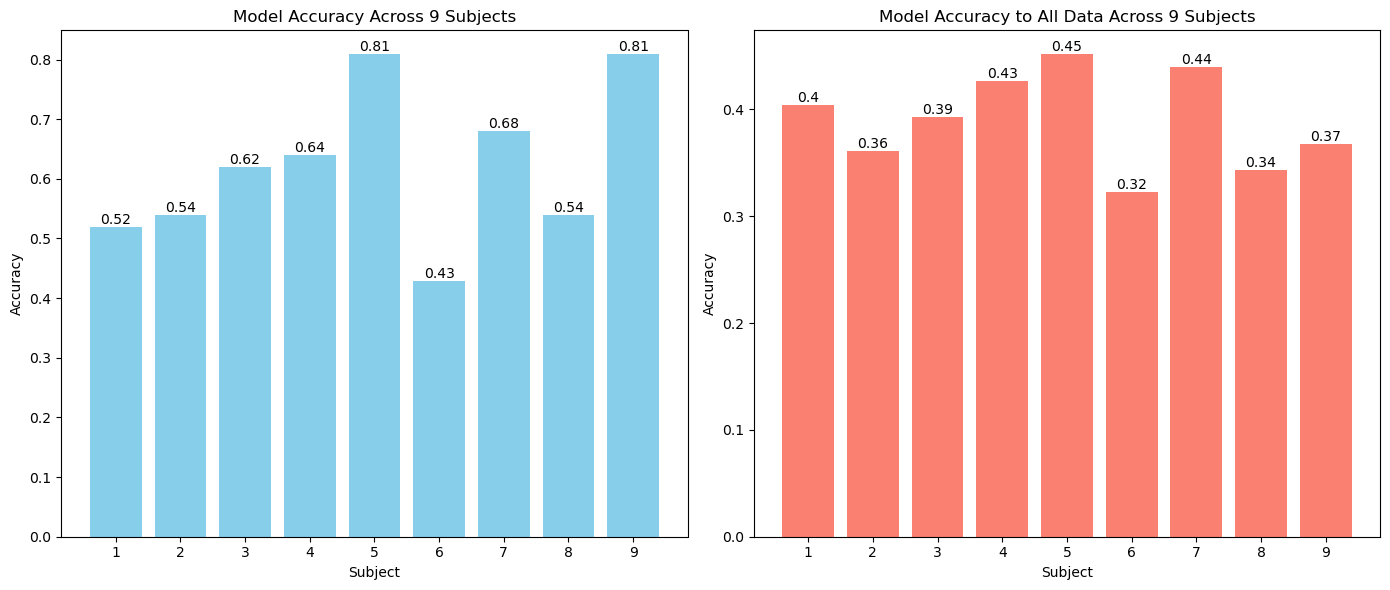

In [25]:
subjects = [i for i in range(1,10)]

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1) 
bars = plt.bar(subjects, acc_subjects, color='skyblue')
plt.title('Model Accuracy Across 9 Subjects')
plt.xlabel('Subject')
plt.ylabel('Accuracy')
plt.xticks(subjects)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.subplot(1, 2, 2) 
bars = plt.bar(subjects, acc_subject_v_all, color='salmon')
plt.title('Model Accuracy to All Data Across 9 Subjects')
plt.xlabel('Subject')
plt.ylabel('Accuracy')
plt.xticks(subjects)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Train based on timestamps

In [20]:
acc_timestamps = []

for j in range(100, 1001, 100):
    X_train, y_train, X_test, y_test = init_data(subject=None, verbose=False)
    ind_valid = np.random.choice(X_train.shape[0], int(0.1 * X_train.shape[0]), replace=False)
    ind_train = np.array(list(set(range(X_train.shape[0])).difference(set(ind_valid))))
    (x_train, x_valid) = X_train[ind_train], X_train[ind_valid]
    (y_train, y_valid) = y_train[ind_train], y_train[ind_valid]

    X_train = x_train[:, :, :j]
    X_valid = x_valid[:, :, :j]
    X_test = X_test[:, :, :j]
    X__train_max = np.max(X_train.reshape(X_train.shape[0], X_train.shape[1], -1, 2), axis=3)
    X_test_max = np.max(X_test.reshape(X_test.shape[0], X_test.shape[1], -1, 2), axis=3)
    X_average_train = np.mean(X_train.reshape(X_train.shape[0], X_train.shape[1], -1, 2), axis=3)
    X_average_train = X_average_train + np.random.normal(0.0, 0.5, X_average_train.shape)
    X__valid_max = np.max(X_valid.reshape(X_valid.shape[0], X_valid.shape[1], -1, 2), axis=3)
    X_average_valid = np.mean(X_valid.reshape(X_valid.shape[0], X_valid.shape[1], -1, 2), axis=3)
    X_average_valid = X_average_valid + np.random.normal(0.0, 0.5, X_average_valid.shape)
    total_X_train = np.vstack((X__train_max, X_average_train))
    total_y_train = np.hstack((y_train, y_train))
    total_X_valid = np.vstack((X__valid_max, X_average_valid))
    total_y_valid = np.hstack((y_valid, y_valid))
    for i in range(2):
        X_subsample = X_train[:, :, i::2] + np.random.normal(0.0, 0.5, X_train[:, :, i::2].shape)

        total_X_train = np.vstack((total_X_train, X_subsample))
        total_y_train = np.hstack((total_y_train, y_train))

    for i in range(2):
        X_subsample = X_valid[:, :, i::2] + np.random.normal(0.0, 0.5, X_valid[:, :, i::2].shape)
        total_X_valid = np.vstack((total_X_valid, X_subsample))
        total_y_valid = np.hstack((total_y_valid, y_valid))

    x_train_aug, y_train_aug, x_valid_aug, y_valid_aug, x_test_aug, y_test_aug = load_data(total_X_train, total_y_train, total_X_valid, total_y_valid, X_test_max, y_test, verbose=True)


    dropout = 0.55
    learning_rate = 0.0007
    epochs = 100
    weight_decay = 0.05
    
    model = Sequential()
    
    model.add(Conv2D(filters=25, kernel_size=(12,1), padding='same', activation='elu', input_shape=(x_train_aug.shape[1],1,22), kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=50, kernel_size=(12,1), padding='same', activation='elu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D(pool_size=(3,1), strides=(3,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Flatten())
    model.add(Dense(50, activation='elu', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay), kernel_initializer='he_uniform'))
    model.add(Dense(4, activation='softmax', kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay), kernel_initializer='he_uniform'))

    early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,        
                           verbose=1,         
                           mode='min',         
                           restore_best_weights=True)
    lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.1)
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    
    model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])
    
    results = model.fit(x_train_aug,
                y_train_aug,
                batch_size=64,
                epochs=epochs,
                validation_data=(x_valid_aug, y_valid_aug), callbacks=[lr_callback], verbose=0)

    score = model.evaluate(x_test_aug, y_test_aug, verbose=0)
    print(f'Test accuracy for timestamp {j}: {score[1]}')
    acc_timestamps.append(score[1])



Training data shape: (7616, 50, 1, 22) Training target shape: (7616, 4)
Validation data shape: (844, 50, 1, 22) Validation target shape: (844, 4)
Testing data shape: (443, 50, 1, 22) Testing target shape: (443, 4)
Test accuracy for timestamp 100: 0.5349887013435364
Training data shape: (7616, 100, 1, 22) Training target shape: (7616, 4)
Validation data shape: (844, 100, 1, 22) Validation target shape: (844, 4)
Testing data shape: (443, 100, 1, 22) Testing target shape: (443, 4)
Test accuracy for timestamp 200: 0.6817155480384827
Training data shape: (7616, 150, 1, 22) Training target shape: (7616, 4)
Validation data shape: (844, 150, 1, 22) Validation target shape: (844, 4)
Testing data shape: (443, 150, 1, 22) Testing target shape: (443, 4)
Test accuracy for timestamp 300: 0.7042889595031738
Training data shape: (7616, 200, 1, 22) Training target shape: (7616, 4)
Validation data shape: (844, 200, 1, 22) Validation target shape: (844, 4)
Testing data shape: (443, 200, 1, 22) Testing ta

Text(0, 0.5, 'Accuracy')

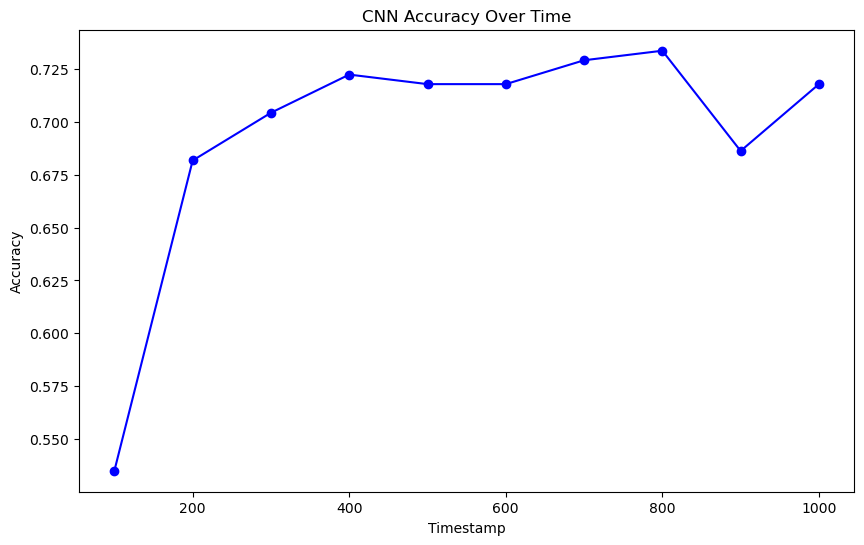

In [21]:
timestamps = [i for i in range(100, 1001, 100)]
plt.figure(figsize=(10, 6))
plt.plot(timestamps, acc_timestamps, marker='o', linestyle='-', color='b')

plt.title('CNN Accuracy Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Accuracy')